<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/%ED%85%8C%EC%8A%A4%ED%8A%B8_%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5_ver0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

어떤 상태에서 특정한 액션을 취하면 리워드가 발생한다.
정책신경망에서 어떤 상태일때 액선이 산출되고 그 산출로 인한 리워드가 최대가 되도록 정책신경망의 가중치를 조정한다. 그러면 리워드가 최대가 되는 액션을 산출하는 정책신경망이 될 것이다. 

loss함수는 리워드가 최대가 되는 액션을 산출했을 때, 마이너스 무한대가 되도록 조정하면 된다. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

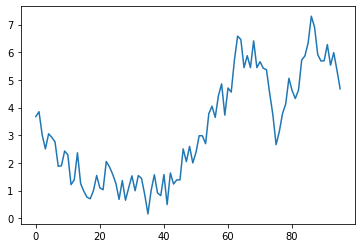

In [7]:
# 환경 모듈

def env():
  start_price = 3
  pricej=[]
  for i in range(100):
    change = np.random.rand(1)*1.2
    direction = np.random.choice(2, p=[0.5, 0.5])
    if direction == 1:
      if start_price - change[0] <= 0:
         p = 1.0
      else:
         p = start_price - change[0]     
    else: 
      p = start_price + change[0] 
    start_price = p
    pricej.append(p)
#  p_mean = np.mean(price)
#  p_std = np.std(price)
#  price = (price - p_mean)/p_std
  
  p_serise= []
  for i in range(96):
    serise = [pricej[i],pricej[i+1], pricej[i+2], pricej[i+3], pricej[i+4]]
    serise = np.array(serise)
    p_serise.append(serise)
  p_serise= p_serise[0:100]
  p_serise = np.array(p_serise)
  p_serise_lstm = p_serise.reshape(96, 5, 1)  # p_serise의 길이는 46이다. LSTM을 사용할 때 데이터 input 형태
  price_lstm = pricej[4:]
  price_lstm = np.array(price_lstm)
  return p_serise, p_serise_lstm, price_lstm 

p_serise, p_serise_lstm, price_lstm = env()
plt.plot(price_lstm)
plt.show()

In [ ]:
p_serise_lstm.shape

(46, 5, 1)

In [ ]:
price_data = [p_serise_lstm[j] for j in range(5)] 
price_data = np.array(price_data)
price_data.shape

(5, 5, 1)

In [ ]:
price_lstm[-1]

4.026364234027149

여기부터 정책신경망 이다.

In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import keras.layers as layers
from keras.layers import LSTM, Dense, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K  # 케라스의 backend를 K. 형식으로 호출하는 것이고 여기서는 tensorflow이다.
import tensorflow as tf

y_true, y_pred는 매트릭스이다. 즉 [y1_true, y2_ture],  [y1_pred, y2_pred]가 한쌍의 샘플이 되고 이러한 샘플이 m개로 구성된 메트릭스로 이해하면된다.


In [ ]:
  # 이것은 예제의 오리지널 custom_loss 함수이다.

  def custom_loss(y_true, y_pred):
    log_lik = K.log(y_pred + 1e-10)*y_true
    return K.mean(tf.tensordot(log_lik, adv, 0), keepdims=True)


In [4]:
 def custom_loss_test(y_true, y_pred):
   log_lik = K.log(y_pred + 1e-10)*y_true
   return log_lik 

y_pred = np.array([[0.5, 0.5],[0.1,0.1]])
y_true = np.array([[1.0,0.0],[0.0, 1.0]])

custom_loss_test(y_true, y_pred)

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[-0.69314718, -0.        ],
       [-0.        , -2.30258509]])>

In [6]:
 # 가장 적합한 손실함수의 하나이다
 
 def custom_loss_test1(y_true, y_pred):
   log_lik = K.sum(K.log(y_pred + 1e-10)*y_true, axis=1)*m
   return log_lik # 모든 샘플의 크로스엔트로피의 평균인데, n의 배수로 나누어준 값이 된다.


y_pred = np.array([[0.5, 0.5],[0.1,0.1]])
y_true = np.array([[1.0,0.0],[0.0, 1.0]])
m = np.array([-1.0]) 

custom_loss_test1(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.69314718, 2.30258509])>

In [ ]:
# 가장 적합한 형태는 custom_loss_test1 or 2인 것 같다. 

def custom_loss_test2(y_true, y_pred):
  log_lik = K.log(y_pred + 1e-10)*y_true
  return K.mean(K.sum(log_lik*m, axis=1)) # 모든 샘플의 크로스엔트로피의 평균인데, n의 배수로 나누어준 값이 된다.


y_pred = np.array([[0.5, 0.5],[0.1,0.1]])
y_true = np.array([[1.0,0.0],[0.0, 1.0]])
m = np.array([-1.0]) 

custom_loss_test2(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=1.4978661361769956>

custom loss함수는 위에서 끝나고 여기부터는 정책신경망에 대한 디자인이다.

In [8]:
# loss 함수가 test1, test2 모두 미분가능한 loss 함수로 적용가능하고 어떤 것이 좋은 것인지는 분석을 해야 한다.

def get_policy_model(lr):
  
  adv = layers.Input(shape=[1])
  inp_L = layers.Input(shape=(7,1))  # 타입스텝수 7개, 특성개수 1개
  dense1 = LSTM(10)(inp_L)
  dense1 = Dense(64)(dense1) 
  dense1 = Dropout(0.5)(dense1)
  dense1 = Dense(64)(dense1)
  output_s = layers.Dense(2, activation="sigmoid",kernel_initializer=glorot_uniform(seed=42), use_bias=False, kernel_regularizer=keras.regularizers.l2(0.001), name="out")(dense1)



  model_train = Model(inputs=[inp_L, adv], outputs = output_s)
  model_train.compile(loss=custom_loss_test1, optimizer=Adam(lr), metrics = ['mae'])
  model_predict = Model(inputs=[inp_L], outputs=output_s)   # model_train.predict와 model_predict.predict의 결과는 완전히 일치한다. 다만 입력의 편의를 위해서 분리한다.
  return model_train, model_predict 

여기까지가 custom_loss 함수에 대한 test를 진행한 부분이다.

In [10]:
model_train, model_predict = get_policy_model(0.01)

In [11]:
model_train.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 10)           480         input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           704         lstm[0][0]                       
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64)           0           dense[0][0]                      
_______________________________________________________________________________________

In [12]:
model_predict.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
out (Dense)                  (None, 2)                 128       
Total params: 5,472
Trainable params: 5,472
Non-trainable params: 0
____________________________________________________

In [13]:
#정책망이 예측한 대로 action을 선택한다.

def action_choice(p_serise_lstm):
  act = model_predict.predict(p_serise_lstm)
  #act = np.argmax(act)
  return act

In [14]:
# action_choice가 선택한 행동을 balance에 대비해서 가능한 행동인지 점검하고 틀린 경우 가능한 액션을 제시한다.
# 당초 0 매수, 1 매도를 --> 0 매수, 1 hold, 2 매도로 전환 
# 그리고 현재의 밸러스는 before 밸런스로 기록을 남긴다.

def action_validate(act, price, balance):
  if act == 0:
    if balance[0] - price < 0:
      act_v = 1
    else:
      act_v = 0
        
  if act == 1:
    if balance[2] > 0 :
      act_v = 2
    else:
      act_v = 1

  before_act_balance = [balance[0], balance[1], balance[2]] 

  return act_v, before_act_balance

In [15]:
# 검증이 완료된 행동으로 현재 밸런스를 갱신하고, 현재 가치를 구한다.

def balance_update(balance, price, act_v):
  if act_v == 0:
    balance[0] = balance[0] - price
    balance[1] = price
    balance[2] = balance[2] + 1
  if act_v == 1:
    balance[1] = price
  if act_v == 2:
    balance[0] = balance[0] + price
    balance[1] = price
    balance[2] = balance[2] -1
  balance_updated = [balance[0], balance[1], balance[2]] 
  present_value = balance[0] + balance[1] * balance[2]
  return balance_updated, present_value

In [16]:
# 이전의 밸런스와 현재 밸런스와의 비율을 구한다. 이것은 포트폴리오 가치비율이라고 한다

def pv_ratio_cal(before_act_balance, balance_updated):
  pv_ratio = (balance_updated[0] + balance_updated[1] * balance_updated[2])/(before_act_balance[0] + before_act_balance[1] * before_act_balance[2])
  return pv_ratio

In [17]:
# 주식보유 비율을 구한다.

def hold_ratio_cal(balance_updated, price):
  hold_ratio = balance_updated[2] / (present_value / price)

  return hold_ratio


In [18]:
# delayed reward를 구하기 위해서 기준 포트폴리오와 현재 밸런스의 비율을 구하고, 타겟 비율을 넘는지 확인한다.
# 만약 target을 넘으면 base_pv를 present_value를 변경한다.

def base_to_cur (base_pv, present_value, target_ratio):
  delay_ratio = (present_value - base_pv) / base_pv
  if delay_ratio > target_ratio:
    target = 1.0
    base_pv = present_value

  elif (-1 * delay_ratio) > target_ratio:
    target = -1.0
    base_pv = present_value
    
  else:
    target = 0
    base_pv = base_pv
    
  return delay_ratio, target, base_pv

In [19]:
# 거래와 관련된 모든 것을 기록한다.

def record(i, price, act, act_v, balance_updated, present_value, pv_ratio, hold_ratio, delay_ratio, target, base_pv):

  transaction_history.append([i, price, act, act_v, balance_updated, present_value, pv_ratio, hold_ratio, delay_ratio, target, base_pv])
  return transaction_history

In [20]:
# 학습을 위한 배치 데이터를 만든다.


def discount_rewards(r, gamma=0.5):
    """Takes 1d float array of rewards and computes discounted reward
    e.g. f([1, 1, 1], 0.99) -> [1, 1.99, 2.9701]
    """
    prior = 0
    out = []
    r = r[::-1]
    for val in r:
        new_val = val + prior * gamma
        out.append(new_val)
        prior = new_val
    return np.array(out)




def get_batch(transaction_history, target):

  for i in range(len(transaction_history)):

    y = np.full((len(transaction_history), 2), 0.0) 
    for j in range(i+1):
      k = transaction_history[j][2] # k는 당초 신경망이 추천한 값으로 0구매, 1는 매도 이다. 
      #y[j,k] = (target + 1.0) / 2 
      y[j,k] = np.abs(target)
      
    price_data = [p_serise_lstm[j] for j in range(i+1)]
    delay_ratios = [transaction_history[j][8] for j in range(i+1)]
    hold_ratios = [transaction_history[j][7] for j in range(i+1)]
      
    train_input =[]
    for pd, dr, hr in zip(price_data, delay_ratios, hold_ratios):
      pd = np.append(pd, dr)
      pd = np.append(pd, hr)
      train_input.append(pd)
    train_input = np.array(train_input)
    train_input = train_input.reshape(-1,7,1)

  adv = np.full((len(transaction_history), 1), 1.0*target) # 긍정학습, 부정학습을 구분하기 위한 것이다.
  adv = discount_rewards(adv)

  return y, train_input, adv


여기부터는 학습의 영역이다.

In [21]:
# random action과 신경망의 선택 action을 조정해야 한다.


num_episode = 0.0
num_episodes = 100.0

target_ratio = 0.05
max_batch_size = 46
epsilon = 0.8


while num_episode < num_episodes:

  balance = [20, 0, 0]
  base_pv = 20
  
  history_record = []
  transaction_history=[]

  for i in range(len(p_serise_lstm)):
   
    price = p_serise_lstm[i][4]

    if np.random.rand() < epsilon :
      act = np.random.choice(2, p=[0.5, 0.5])
    else:
      act =  np.argmax(action_choice(p_serise_lstm)[i])
   
    act_v, before_act_balance = action_validate(act, price, balance)
    
    balance_updated, present_value = balance_update(balance, price, act_v)
    pv_ratio = pv_ratio_cal(before_act_balance, balance_updated)
    hold_ratio = hold_ratio_cal(balance_updated, price)
   
    delay_ratio, target, base_pv = base_to_cur(base_pv, present_value, target_ratio)
  
    transaction_history = record(i, price, act, act_v, balance_updated, present_value, pv_ratio, hold_ratio, delay_ratio, target, base_pv)



    if (target == 1 or target == -1):
      y, train_input, adv = get_batch(transaction_history, target)
#      print(train_input.shape)
#      print(input("check?"))

      y = np.array(y)
      loss = model_train.train_on_batch([train_input, adv], y)
      

      history_record.append(transaction_history)
      transaction_history=[]
      continue

    if i == (len(p_serise_lstm)-1):

      history_record.append(transaction_history)
      transaction_history=[]      

    
  if present_value > 50.0:
    break
  if (num_episode+1) % 2 == 0:
    print("num_episode: ",num_episode+1, "loss: ", loss[0], "mse :", loss[1], "wealth:", present_value)

  num_episode += 1.0
  epsilon = epsilon * ( 1 - num_episode/num_episodes)








    

num_episode:  2.0 loss:  0.003937434405088425 mse : 0.5 wealth: [44.67656798]


In [ ]:
transaction_history

[]

In [22]:
history_record

[[[0,
   array([3.67605401]),
   1,
   1,
   [20, array([3.67605401]), 0],
   array([20.]),
   array([1.]),
   array([0.]),
   array([0.]),
   0,
   20],
  [1,
   array([3.85126705]),
   0,
   0,
   [array([16.14873295]), array([3.85126705]), 1],
   array([20.]),
   array([1.]),
   array([0.19256335]),
   array([0.]),
   0,
   20],
  [2,
   array([3.00708514]),
   1,
   2,
   [array([19.15581808]), array([3.00708514]), 0],
   array([19.15581808]),
   array([0.9577909]),
   array([0.]),
   array([-0.0422091]),
   0,
   20],
  [3,
   array([2.50685955]),
   0,
   0,
   [array([16.64895853]), array([2.50685955]), 1],
   array([19.15581808]),
   array([1.]),
   array([0.13086674]),
   array([-0.0422091]),
   0,
   20],
  [4,
   array([3.0537632]),
   1,
   2,
   [array([19.70272173]), array([3.0537632]), 0],
   array([19.70272173]),
   array([1.02855026]),
   array([0.]),
   array([-0.01486391]),
   0,
   20],
  [5,
   array([2.92631831]),
   1,
   1,
   [array([19.70272173]), array([2.926

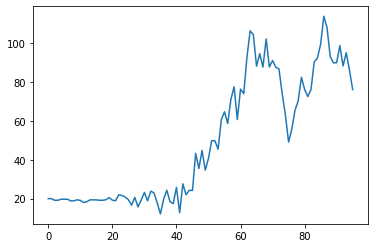

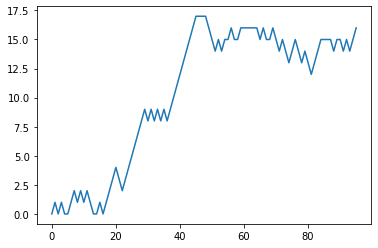

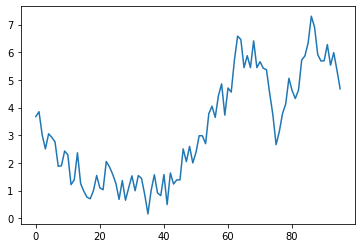

In [23]:
fk = np.array(history_record)
fkn = []
for i in range(len(fk)):
  for j in range(len(fk[i])):
    fkn.append(fk[i][j]) 

wealth = []
for i in range(len(fkn)):
  wealth.append(fkn[i][5])

stock = []
for i in range(len(fkn)):
  stock.append(fkn[i][4][2])

plt.plot(wealth)
plt.show()

plt.plot(stock)
plt.show()

plt.plot(price_lstm)
plt.show()

결전 테스트 테스트 테스트

In [ ]:
y = np.full((5, 2), 0.5)
y

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [ ]:
kk = [1,0,1,0,1]
for i, k in enumerate(kk):
  y[i,k] = 1.0

y

array([[0.5, 1. ],
       [1. , 0.5],
       [0.5, 1. ],
       [1. , 0.5],
       [0.5, 1. ]])

In [ ]:
x = [np.array([5.0, 7.0]), np.array([6.0, 3.0]), np.array([2.0, 9.0]), np.array([5.0, 2.0]), np.array([3.0, 5.0])]
x = np.array(x)
x

array([[5., 7.],
       [6., 3.],
       [2., 9.],
       [5., 2.],
       [3., 5.]])

In [ ]:
from tensorflow import keras
import keras.layers as layers
from keras.layers import LSTM, Dense, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop

In [ ]:
def get_policy_model(lr):
  
  inp_L = layers.Input(shape=(5,1))  # 타입스텝수 7개, 특성개수 1개
  dense1 = LSTM(10)(inp_L)
  dense1 = Dense(64)(dense1) 
  dense1 = Dropout(0.5)(dense1)
  dense1 = Dense(64)(dense1)
  output_s = layers.Dense(1)(dense1)

  model_train = Model(inputs=inp_L, outputs = output_s)
  model_train.compile(loss='mse', optimizer=Adam(lr), metrics = ['mae'])
  model_predict = Model(inputs=inp_L, outputs=output_s)
  return model_train, model_predict

In [ ]:
model_train, model_predict = get_policy_model(0.01)

In [ ]:
model_train.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                704       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
___________________________________________________

In [ ]:
history = model_train.fit(p_serise_lstm, price_lstm, epochs=10)

Epoch 1/10
3/3 [==============================] - 0s 3ms/step - loss: 12.0193 - mae: 2.7826
Epoch 2/10
3/3 [==============================] - 0s 3ms/step - loss: 4.1420 - mae: 1.7935
Epoch 3/10
3/3 [==============================] - 0s 3ms/step - loss: 3.0824 - mae: 1.4788
Epoch 4/10
3/3 [==============================] - 0s 6ms/step - loss: 2.8924 - mae: 1.2820
Epoch 5/10
3/3 [==============================] - 0s 3ms/step - loss: 1.5044 - mae: 0.9103
Epoch 6/10
3/3 [==============================] - 0s 3ms/step - loss: 1.5784 - mae: 0.9893
Epoch 7/10
3/3 [==============================] - 0s 3ms/step - loss: 0.9732 - mae: 0.8175
Epoch 8/10
3/3 [==============================] - 0s 3ms/step - loss: 1.3706 - mae: 0.9635
Epoch 9/10
3/3 [==============================] - 0s 3ms/step - loss: 0.7576 - mae: 0.6973
Epoch 10/10
3/3 [==============================] - 0s 3ms/step - loss: 1.3460 - mae: 0.8538


In [ ]:
model_train.predict(p_serise_lstm) == model_predict.predict(p_serise_lstm)

여기가 끝이다.

In [ ]:
aj = np.array([[0.5, 0.5], [0.5,0.7]])

aj[0,0] = 1.0

aj

array([[1. , 0.5],
       [0.5, 0.7]])

In [ ]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
y_encoded = keras.utils.to_categorical(action, 2) # 분류 갯수를 정하기 위한 인수(2)가 필요하다.

In [ ]:
def balance_update(predict, p_serise):

  acts = []
  balance = [100, 0, 0]  #[자본금, 종가, 보유주식수] 이다.
  blist = [[100.0, 0.0, 0.0]]
  for i in range(len(predict)):
    action = np.random.choice(3,p=predict[i]) # 대안 중에서 하나를 선택한다. 
    
    if action == 0 and (balance[0] - p_serise[i][4]) < 0:
      ps = predict[i][1] + predict[i][2]
      pn = [predict[i][1],predict[i][2]]/ps
      action = 1+ np.random.choice(2,p=pn) 

    if action == 2 and balance[2] <= 0:
      ps = predict[i][0] + predict[i][1]
      pn = [predict[i][0],predict[i][1]]/ps
      action = np.random.choice(2,p=pn)  

    if action == 1:  # hold
      balance[1] = p_serise[i][4]

    if action  == 0:  # buy
      balance[0] = balance[0] - p_serise[i][4]
      balance[1] = p_serise[i][4]
      balance[2] = balance[2] + 1

    if action  == 2:
      balance[0] = balance[0] + p_serise[i][4]
      balance[1] = p_serise[i][4]
      balance[2] = balance[2] - 1 
     
    blist.append([balance[0], balance[1], balance[2]])
    acts.append(action)
  return blist, acts

In [ ]:
def reward_portfolio (blist):   

  reward_sum_list=[]
  reward_list=[]
   

  for a in blist:
    reward_sum = a[0] + a[1] * a[2]
    reward_sum_list.append(reward_sum)

  for i in range(len(reward_sum_list)-1):
    reward = np.abs(reward_sum_list[i+1] - reward_sum_list[i]) # 가중치를 일괄적으로 양 수로 만들어서 손실함수 계산의 방향을 일관되게 만든다.
    reward_list.append(reward)      
  return reward_sum_list, reward_list



In [ ]:
r = [1.0, 1.0, 1.0, 1.0]

discount_rewards(r)

array([1.   , 1.5  , 1.75 , 1.875])

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import keras.layers as layers
from keras.layers import LSTM, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K  # 케라스의 backend를 K. 형식으로 호출하는 것이고 여기서는 tensorflow이다.

Using TensorFlow backend.


In [ ]:
def get_policy_model(lr):
  inp_L = layers.Input(shape=(5,),name="input_L")
  multip = layers.Input(shape=[1], name="advantages")
  dense_L = Dense(64)(inp_L)
  output_s = layers.Dense(3, activation="softmax",kernel_initializer=glorot_uniform(seed=42), use_bias=False, kernel_regularizer=keras.regularizers.l2(0.001), name="out")(dense_L)

  model_train = Model(inputs=[inp_L, multip], outputs = output_s)

  # loss 함수를 actual과 predict가 같을때 -무한대가 되도록 만든다. 완전히 틀리면 0 이므로 loss 함수의 값의 범위는 -무한대 ~ 0 이다.
  def custom_loss(y_true, y_pred):
    # actual: 0 predict: 0 -> log(0 * (0 - 0) + (1 - 0) * (0 + 0)) = -inf   log(0) = - inf
    # actual: 1 predict: 1 -> log(1 * (1 - 1) + (1 - 1) * (1 + 1)) = -inf   
    # actual: 1 predict: 0 -> log(1 * (1 - 0) + (1 - 1) * (1 + 0)) = 0      log(1) = 0
    # actual: 0 predict: 1 -> log(0 * (0 - 1) + (1 - 0) * (0 + 1)) = 0
    a = y_true * (y_true - y_pred) + (1 - y_true) * (y_true + y_pred)
    log_lik = K.log(a)
    return K.mean(log_lik * multip, keepdims=True)

  model_train.compile(loss=custom_loss, optimizer=Adam(lr), metrics = ['mae'])
  model_predict = Model(inputs=[inp_L], outputs = output_s)
  return model_train, model_predict

In [ ]:
model_train, model_predict = get_policy_model(0.00001)

In [ ]:
model_train.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_L (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
out (Dense)                  (None, 3)                 192       
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________
